# Model Selection
Bayesian Optimization for model selection to maximize accuracy.

In [1]:
from src.classifier.ThreadedBayesianSearcher import ThreadedBayesianSearcher
from src.classifier.BayesianTabularModelSearch import BayesianSearcher
from src.classifier.CustomTabularModel import CustomTabularModel
from src.recommender.BayesianRecommender import BayesianRecommender
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [2]:
bayesian_optimizer = BayesianSearcher(20)
model = CustomTabularModel(0.5, False, 1000, {'layer1': 20, 'layer2': 20, 'dropout': 0.5})
bayesian_optimizer.run_optimization(model, {'layer1': (1, 400), 'layer2': (1, 400), 'layer3': (1, 400), 'dropout': (0, 1)})
bayesian_optimizer.run_optimization(model, {'layer1': (1, 400), 'layer2': (1, 400), 'dropout': (0, 1)})
bayesian_optimizer.run_optimization(model, {'layer1': (1, 400), 'dropout': (0, 1)})

epoch,train_loss,valid_loss,accuracy,time
0,0.738952,0.754223,0.153191,00:00
1,0.725692,0.706129,0.208511,00:00
2,0.700259,0.597839,0.846808,00:00
3,0.664044,0.463682,0.846808,00:00
4,0.623925,0.439224,0.846808,00:00
5,0.607476,0.428506,0.846808,00:00


Epoch 6: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.718546,0.748819,0.186761,00:00
1,0.722001,0.741421,0.186761,00:00
2,0.712669,0.730246,0.186761,00:00
3,0.704532,0.716060,0.186761,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.699524,0.710904,0.174941,00:00
1,0.702883,0.706755,0.174941,00:00
2,0.699083,0.699124,0.174941,00:00
3,0.691251,0.686289,0.825059,00:00
4,0.686589,0.667470,0.825059,00:00
5,0.678732,0.641865,0.825059,00:00
6,0.668545,0.611205,0.825059,00:00


Epoch 7: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.729977,0.672473,0.813239,00:00
1,0.720340,0.672867,0.813239,00:00
2,0.714098,0.670068,0.813239,00:00
3,0.704009,0.661269,0.813239,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.711460,0.711391,0.182033,00:00
1,0.738043,0.712221,0.182033,00:00
2,0.732299,0.710751,0.182033,00:00
3,0.720400,0.703092,0.182033,00:00
4,0.708785,0.691639,0.541371,00:00
5,0.707938,0.665342,0.817967,00:00
6,0.697890,0.633014,0.817967,00:00
7,0.683040,0.602275,0.817967,00:00
8,0.673333,0.574941,0.817967,00:00


Epoch 9: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.690089,0.568391,0.820331,00:00
1,0.676345,0.570779,0.820331,00:00
2,0.672344,0.570323,0.820331,00:00
3,0.667068,0.565896,0.820331,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.656772,0.647050,0.817967,00:00
1,0.654617,0.645499,0.817967,00:00
2,0.657796,0.639325,0.817967,00:00
3,0.654422,0.625425,0.817967,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.687701,0.741356,0.170213,00:00
1,0.688413,0.735191,0.170213,00:00
2,0.686698,0.724726,0.170213,00:00
3,0.685240,0.707526,0.170213,00:00
4,0.682357,0.683043,0.829787,00:00
5,0.676687,0.651732,0.829787,00:00
6,0.671107,0.615610,0.829787,00:00
7,0.663314,0.577338,0.829787,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.717640,0.580336,0.815603,00:00
1,0.732072,0.583524,0.815603,00:00
2,0.720447,0.584524,0.815603,00:00
3,0.714631,0.582937,0.815603,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.759943,0.772160,0.172577,00:00
1,0.761811,0.760559,0.172577,00:00
2,0.753645,0.742991,0.172577,00:00
3,0.746887,0.719126,0.172577,00:00
4,0.734732,0.691541,0.817967,00:00
5,0.722489,0.661297,0.827423,00:00
6,0.713378,0.630504,0.827423,00:00
7,0.702234,0.600624,0.827423,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.654441,0.666772,0.803783,00:00
1,0.643983,0.661827,0.803783,00:00
2,0.631006,0.648933,0.808511,00:00
3,0.611764,0.635598,0.808511,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.751491,0.692306,0.768322,00:00
1,0.715749,0.687912,0.820331,00:00
2,0.713715,0.679002,0.820331,00:00
3,0.682662,0.665482,0.820331,00:00
4,0.695245,0.644823,0.820331,00:00


Epoch 5: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.686220,0.661934,0.815603,00:00
1,0.658110,0.658110,0.815603,00:00
2,0.637144,0.650480,0.815603,00:00
3,0.633558,0.638132,0.810875,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.774240,0.705318,0.179669,00:00
1,0.748113,0.700644,0.179669,00:00
2,0.744154,0.689255,0.810875,00:00
3,0.723551,0.673220,0.820331,00:00
4,0.712472,0.653519,0.820331,00:00
5,0.694280,0.624133,0.815603,00:00


Epoch 6: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.721233,0.685209,0.822695,00:00
1,0.659898,0.681017,0.815603,00:00
2,0.634495,0.670424,0.813239,00:00
3,0.581995,0.651070,0.808511,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.767919,0.697845,0.182033,00:00
1,0.716719,0.691886,0.815603,00:00
2,0.698849,0.681219,0.817967,00:00
3,0.671221,0.664029,0.817967,00:00
4,0.662376,0.643491,0.817967,00:00


Epoch 5: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.710010,0.710251,0.184397,00:00
1,0.721974,0.703688,0.186761,00:00
2,0.697242,0.692393,0.527187,00:00
3,0.703901,0.674275,0.815603,00:00
4,0.698557,0.653475,0.815603,00:00
5,0.678613,0.630185,0.815603,00:00
6,0.665736,0.606607,0.815603,00:00


Epoch 7: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.690363,0.682949,0.817967,00:00
1,0.662929,0.678636,0.822695,00:00
2,0.645940,0.669901,0.822695,00:00
3,0.606460,0.654169,0.820331,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.746371,0.694201,0.189125,00:00
1,0.721368,0.687391,0.815603,00:00
2,0.696097,0.674709,0.815603,00:00
3,0.680218,0.655439,0.815603,00:00
4,0.662088,0.625212,0.815603,00:00


Epoch 5: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.784841,0.701311,0.189125,00:00
1,0.744761,0.699999,0.200946,00:00
2,0.707525,0.693443,0.477541,00:00
3,0.681475,0.680714,0.801418,00:00
4,0.682033,0.660300,0.813239,00:00
5,0.647771,0.633596,0.813239,00:00
6,0.643224,0.600882,0.817967,00:00
7,0.620540,0.562001,0.817967,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,1.086975,1.161650,0.177305,00:00
1,1.086753,1.160446,0.177305,00:00
2,1.119533,1.157740,0.177305,00:00
3,1.110088,1.153402,0.177305,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,1.408793,1.419082,0.179669,00:00
1,1.408517,1.417751,0.179669,00:00
2,1.439404,1.414539,0.179669,00:00
3,1.406484,1.409334,0.179669,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.599640,0.607968,0.815603,00:00
1,0.604328,0.607278,0.815603,00:00
2,0.595775,0.605635,0.815603,00:00
3,0.595683,0.603630,0.815603,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.638169,0.531163,0.813239,00:00
1,0.665652,0.531342,0.813239,00:00
2,0.658577,0.530907,0.813239,00:00
3,0.607863,0.530010,0.813239,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.565687,0.504113,0.829787,00:00
1,0.546489,0.503392,0.829787,00:00
2,0.552025,0.502281,0.829787,00:00
3,0.559993,0.500837,0.829787,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.696920,0.689130,0.820331,00:00
1,0.698900,0.687468,0.820331,00:00
2,0.696900,0.684408,0.820331,00:00
3,0.693392,0.680137,0.820331,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.721551,0.762039,0.170213,00:00
1,0.720623,0.762538,0.170213,00:00
2,0.724154,0.761709,0.170213,00:00
3,0.724939,0.758873,0.170213,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.473230,0.500237,0.815603,00:00
1,0.442578,0.499974,0.815603,00:00
2,0.452852,0.499374,0.815603,00:00
3,0.465676,0.498351,0.815603,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.488798,0.568459,0.808511,00:00
1,0.488092,0.568003,0.808511,00:00
2,0.504303,0.566920,0.808511,00:00
3,0.503051,0.565104,0.808511,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.671310,0.671788,0.813239,00:00
1,0.669074,0.671570,0.813239,00:00
2,0.668829,0.670828,0.813239,00:00
3,0.667471,0.669346,0.813239,00:00


Epoch 4: early stopping
Finished
Keeping results: {'target': 0.8153664350509644, 'params': {'dropout': 0.36049303573428904, 'layer1': 287.2621889448561, 'layer2': 179.9018316584037, 'layer3': 273.91930190659644}}


epoch,train_loss,valid_loss,accuracy,time
0,0.771046,0.599217,0.825059,00:00
1,0.752080,0.601137,0.825059,00:00
2,0.716812,0.606245,0.825059,00:00
3,0.715353,0.608059,0.825059,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.906422,0.952856,0.177305,00:00
1,0.916270,0.951794,0.177305,00:00
2,0.919039,0.949278,0.177305,00:00
3,0.914591,0.945158,0.177305,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,1.242134,1.077833,0.191489,00:00
1,1.246955,1.070821,0.191489,00:00
2,1.262067,1.061855,0.191489,00:00
3,1.261095,1.053050,0.191489,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,1.514373,1.578900,0.182033,00:00
1,1.569998,1.577278,0.182033,00:00
2,1.568453,1.573715,0.182033,00:00
3,1.552826,1.567849,0.182033,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.871659,0.858814,0.186761,00:00
1,0.874927,0.857278,0.186761,00:00
2,0.869875,0.854343,0.186761,00:00
3,0.871279,0.850065,0.186761,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.983690,0.945049,0.170213,00:00
1,0.936430,0.946876,0.170213,00:00
2,0.944636,0.946404,0.170213,00:00
3,0.943421,0.942344,0.170213,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,1.105341,0.872708,0.189125,00:00
1,1.040259,0.875034,0.193853,00:00
2,0.998279,0.873598,0.203310,00:00
3,0.984383,0.870877,0.212766,00:00
4,0.977046,0.867194,0.205674,00:00
5,0.977059,0.860740,0.219858,00:00
6,0.971141,0.855666,0.231678,00:00
7,0.965124,0.851055,0.229314,00:00
8,0.955276,0.847901,0.224586,00:00
9,0.948206,0.845423,0.234043,00:00


Epoch 10: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.531979,0.550975,0.810875,00:00
1,0.538322,0.551135,0.810875,00:00
2,0.533366,0.550515,0.810875,00:00
3,0.534469,0.550683,0.810875,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.553674,0.573120,0.813239,00:00
1,0.563793,0.573037,0.813239,00:00
2,0.560637,0.572708,0.813239,00:00
3,0.564067,0.571888,0.813239,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,1.079503,1.074133,0.184397,00:00
1,1.074788,1.069383,0.184397,00:00
2,1.067891,1.064283,0.184397,00:00
3,1.060159,1.056837,0.184397,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.756916,0.747955,0.182033,00:00
1,0.757301,0.745314,0.182033,00:00
2,0.729153,0.737830,0.186761,00:00
3,0.719369,0.726531,0.198582,00:00
4,0.707146,0.711448,0.229314,00:00
5,0.695669,0.692330,0.380615,00:00
6,0.687366,0.671959,0.787234,00:00
7,0.673337,0.641065,0.810875,00:00
8,0.666166,0.617578,0.822695,00:00
9,0.651566,0.593681,0.822695,00:00


Epoch 12: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.697499,0.708709,0.182033,00:00
1,0.695659,0.700762,0.193853,00:00
2,0.686624,0.686156,0.607565,00:00
3,0.661087,0.672930,0.813239,00:00
4,0.664165,0.656324,0.817967,00:00
5,0.643571,0.627493,0.817967,00:00
6,0.635608,0.601852,0.817967,00:00


Epoch 7: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.745988,0.679319,0.810875,00:00
1,0.738068,0.682461,0.810875,00:00
2,0.725372,0.682230,0.810875,00:00
3,0.714326,0.675806,0.810875,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.699574,0.711850,0.189125,00:00
1,0.680804,0.708153,0.189125,00:00
2,0.664527,0.701368,0.226950,00:00
3,0.639394,0.689336,0.685579,00:00
4,0.684355,0.677754,0.784870,00:00
5,0.655937,0.657949,0.799054,00:00
6,0.636393,0.634164,0.796690,00:00
7,0.615616,0.611132,0.791962,00:00
8,0.593732,0.590440,0.789598,00:00


Epoch 9: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.673802,0.704338,0.170213,00:00
1,0.695381,0.698472,0.243499,00:00
2,0.672854,0.688185,0.749409,00:00
3,0.656498,0.671043,0.815603,00:00
4,0.642653,0.647944,0.822695,00:00
5,0.621648,0.624898,0.822695,00:00
6,0.628125,0.603552,0.829787,00:00
7,0.620617,0.583197,0.829787,00:00
8,0.611990,0.560685,0.829787,00:00
9,0.604413,0.540285,0.829787,00:00


Epoch 10: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.712249,0.671388,0.820331,00:00
1,0.697807,0.669644,0.820331,00:00
2,0.688443,0.665379,0.820331,00:00
3,0.676521,0.657903,0.820331,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.741134,0.714535,0.179669,00:00
1,0.716523,0.708973,0.179669,00:00
2,0.688910,0.697686,0.416076,00:00
3,0.717591,0.685725,0.725768,00:00
4,0.697871,0.670563,0.820331,00:00
5,0.687506,0.652806,0.820331,00:00
6,0.675051,0.631005,0.820331,00:00
7,0.659548,0.607598,0.813239,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.725958,0.714713,0.184397,00:00
1,0.722165,0.711021,0.189125,00:00
2,0.710270,0.703811,0.205674,00:00
3,0.714280,0.695950,0.250591,00:00
4,0.706468,0.681968,0.813239,00:00
5,0.699005,0.663917,0.815603,00:00
6,0.691025,0.642558,0.815603,00:00
7,0.677504,0.620235,0.815603,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.798454,0.714414,0.174941,00:00
1,0.773385,0.709577,0.179669,00:00
2,0.762811,0.699559,0.189125,00:00
3,0.742671,0.690472,0.541371,00:00
4,0.717996,0.676059,0.817967,00:00
5,0.709566,0.664438,0.777778,00:00
6,0.713283,0.648738,0.784870,00:00
7,0.705292,0.631676,0.817967,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.689228,0.701608,0.210402,00:00
1,0.683552,0.697589,0.238771,00:00
2,0.659269,0.691272,0.513002,00:00
3,0.677040,0.682226,0.680851,00:00
4,0.654820,0.666032,0.801418,00:00
5,0.630934,0.647292,0.808511,00:00
6,0.610904,0.623522,0.815603,00:00
7,0.589235,0.596634,0.817967,00:00
8,0.597443,0.571815,0.817967,00:00
9,0.577085,0.550202,0.822695,00:00


Epoch 10: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.680021,0.720007,0.177305,00:00
1,0.672813,0.711762,0.177305,00:00
2,0.673421,0.696203,0.177305,00:00
3,0.670290,0.670904,0.822695,00:00
4,0.665982,0.631829,0.822695,00:00
5,0.656622,0.577017,0.822695,00:00
6,0.642040,0.522107,0.822695,00:00


Epoch 7: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.674905,0.707320,0.184397,00:00
1,0.677938,0.705266,0.184397,00:00
2,0.673848,0.694738,0.515366,00:00
3,0.666406,0.682216,0.815603,00:00
4,0.657010,0.634745,0.815603,00:00
5,0.645826,0.599535,0.815603,00:00
6,0.632600,0.547076,0.815603,00:00


Epoch 7: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.689209,0.683688,0.815603,00:00
1,0.685332,0.675174,0.815603,00:00
2,0.692701,0.669300,0.815603,00:00
3,0.685478,0.653678,0.815603,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.654030,0.677339,0.839243,00:00
1,0.673665,0.674231,0.839243,00:00
2,0.671130,0.664095,0.839243,00:00
3,0.671756,0.643055,0.839243,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.681363,0.659535,0.810875,00:00
1,0.679953,0.658942,0.810875,00:00
2,0.677308,0.666335,0.810875,00:00
3,0.672035,0.660142,0.799054,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.651171,0.749281,0.182033,00:00
1,0.641670,0.750438,0.182033,00:00
2,0.642271,0.751288,0.182033,00:00
3,0.665005,0.721699,0.182033,00:00
4,0.652205,0.684695,0.817967,00:00
5,0.632666,0.636348,0.817967,00:00
6,0.614814,0.582457,0.817967,00:00
7,0.600133,0.527843,0.817967,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.696255,0.840548,0.167849,00:00
1,0.698687,0.817552,0.167849,00:00
2,0.692732,0.789558,0.170213,00:00
3,0.686544,0.771971,0.167849,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.693667,0.651360,0.813239,00:00
1,0.692886,0.648438,0.813239,00:00
2,0.691693,0.641016,0.813239,00:00
3,0.686483,0.627288,0.813239,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.696790,0.744340,0.179669,00:00
1,0.696439,0.736550,0.179669,00:00
2,0.694591,0.720756,0.179669,00:00
3,0.690782,0.690977,0.820331,00:00
4,0.681983,0.640363,0.820331,00:00
5,0.669154,0.569850,0.820331,00:00
6,0.650977,0.502373,0.820331,00:00


Epoch 7: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.688573,0.641472,0.813239,00:00
1,0.678349,0.637504,0.813239,00:00
2,0.665557,0.624683,0.813239,00:00
3,0.658788,0.604769,0.813239,00:00


Epoch 4: early stopping
Finished
Keeping results: {'target': 0.8167848706245422, 'params': {'dropout': 0.531041045008388, 'layer1': 257.8577693090355, 'layer2': 114.59873517131032}}


epoch,train_loss,valid_loss,accuracy,time
0,0.658849,0.661932,0.751773,00:00
1,0.715831,0.659755,0.761229,00:00
2,0.703707,0.650106,0.806147,00:00
3,0.684494,0.632291,0.810875,00:00
4,0.668331,0.608905,0.810875,00:00
5,0.648823,0.580539,0.808511,00:00


Epoch 6: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.685618,0.623240,0.817967,00:00
1,0.681364,0.622324,0.817967,00:00
2,0.678441,0.617228,0.817967,00:00
3,0.672678,0.606813,0.817967,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.736630,0.677381,0.791962,00:00
1,0.741240,0.677326,0.791962,00:00
2,0.736807,0.673589,0.756501,00:00
3,0.729854,0.660752,0.813239,00:00
4,0.719151,0.641789,0.813239,00:00
5,0.706301,0.615981,0.813239,00:00
6,0.688934,0.585421,0.813239,00:00


Epoch 7: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.738757,0.750228,0.184397,00:00
1,0.742063,0.741610,0.184397,00:00
2,0.719246,0.723917,0.189125,00:00
3,0.702130,0.694872,0.411348,00:00
4,0.690748,0.661400,0.815603,00:00
5,0.681737,0.623242,0.813239,00:00
6,0.660920,0.588076,0.810875,00:00
7,0.640812,0.561227,0.806147,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.694984,0.670368,0.626478,00:00
1,0.694958,0.661876,0.737589,00:00
2,0.691649,0.647770,0.751773,00:00
3,0.686313,0.626121,0.806147,00:00
4,0.676131,0.603958,0.806147,00:00
5,0.663292,0.578160,0.806147,00:00
6,0.651059,0.547285,0.806147,00:00


Epoch 7: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.708939,0.689540,0.524823,00:00
1,0.713405,0.686831,0.553191,00:00
2,0.715721,0.677352,0.803783,00:00
3,0.705483,0.660800,0.799054,00:00
4,0.684966,0.643166,0.761229,00:00
5,0.674830,0.626418,0.768322,00:00


Epoch 6: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.729643,0.755410,0.193853,00:00
1,0.719609,0.749894,0.205674,00:00
2,0.718523,0.736564,0.208038,00:00
3,0.710964,0.715398,0.236407,00:00
4,0.701525,0.682240,0.810875,00:00
5,0.692731,0.643847,0.810875,00:00
6,0.677785,0.597305,0.810875,00:00
7,0.660480,0.548840,0.810875,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.845046,0.757067,0.193853,00:00
1,0.806769,0.745464,0.205674,00:00
2,0.807887,0.724640,0.219858,00:00
3,0.784862,0.699461,0.314421,00:00
4,0.761081,0.676197,0.657210,00:00
5,0.738414,0.647608,0.791962,00:00
6,0.719999,0.616296,0.803783,00:00
7,0.701866,0.584746,0.810875,00:00
8,0.687010,0.553177,0.817967,00:00
9,0.667121,0.521027,0.817967,00:00


Epoch 12: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.683749,0.659731,0.827423,00:00
1,0.705255,0.653508,0.825059,00:00
2,0.693688,0.639792,0.817967,00:00
3,0.687848,0.633051,0.777778,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.674225,0.765609,0.182033,00:00
1,0.668703,0.751842,0.182033,00:00
2,0.667491,0.730165,0.217494,00:00
3,0.670958,0.711621,0.295508,00:00
4,0.670382,0.692988,0.546099,00:00
5,0.657805,0.699483,0.697400,00:00
6,0.647438,0.726775,0.749409,00:00
7,0.639921,0.618140,0.796690,00:00
8,0.620986,0.533133,0.815603,00:00
9,0.607013,0.501726,0.815603,00:00


Epoch 12: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.712624,0.633459,0.820331,00:00
1,0.709263,0.634060,0.820331,00:00
2,0.706213,0.632738,0.820331,00:00
3,0.695077,0.628462,0.820331,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.696328,0.709693,0.179669,00:00
1,0.699648,0.707679,0.432624,00:00
2,0.695734,0.702425,0.562648,00:00
3,0.694866,0.695436,0.586288,00:00
4,0.690687,0.684140,0.671395,00:00
5,0.686110,0.668984,0.723404,00:00
6,0.681949,0.650821,0.780142,00:00
7,0.676880,0.631214,0.822695,00:00
8,0.668559,0.610556,0.822695,00:00
9,0.663696,0.592756,0.822695,00:00


Epoch 11: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.739716,0.694392,0.404255,00:00
1,0.746184,0.693153,0.432624,00:00
2,0.741117,0.689929,0.494090,00:00
3,0.738022,0.684003,0.683215,00:00
4,0.731537,0.674804,0.810875,00:00
5,0.722763,0.663293,0.810875,00:00
6,0.712720,0.649694,0.810875,00:00
7,0.701171,0.634582,0.810875,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.767995,0.727364,0.250591,00:00
1,0.759933,0.728279,0.252955,00:00
2,0.748265,0.725071,0.260047,00:00
3,0.738267,0.718546,0.288416,00:00
4,0.733579,0.708619,0.399527,00:00
5,0.727682,0.696858,0.527187,00:00
6,0.719403,0.681969,0.621749,00:00
7,0.702017,0.665701,0.666667,00:00
8,0.692227,0.649597,0.699764,00:00
9,0.680661,0.633747,0.702128,00:00


Epoch 17: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.729900,0.700624,0.281324,00:00
1,0.720319,0.697073,0.314421,00:00
2,0.721661,0.690212,0.378251,00:00
3,0.717824,0.679773,0.650118,00:00
4,0.711210,0.665850,0.799054,00:00
5,0.703616,0.650034,0.813239,00:00
6,0.695045,0.633753,0.813239,00:00
7,0.684713,0.616605,0.813239,00:00
8,0.674553,0.599375,0.813239,00:00


Epoch 9: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.638350,0.625015,0.825059,00:00
1,0.641321,0.624696,0.825059,00:00
2,0.647887,0.621983,0.825059,00:00
3,0.642141,0.617386,0.825059,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.736336,0.679951,0.832151,00:00
1,0.737145,0.679230,0.832151,00:00
2,0.731197,0.676569,0.829787,00:00
3,0.720456,0.671455,0.832151,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.663197,0.666537,0.706856,00:00
1,0.659406,0.668785,0.699764,00:00
2,0.653735,0.670972,0.690307,00:00
3,0.660029,0.672068,0.690307,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.734613,0.693284,0.361702,00:00
1,0.731942,0.692632,0.368794,00:00
2,0.737525,0.689039,0.411348,00:00
3,0.734980,0.682604,0.664303,00:00
4,0.730893,0.672916,0.806147,00:00
5,0.724440,0.661801,0.817967,00:00
6,0.717451,0.648295,0.815603,00:00
7,0.707630,0.633454,0.806147,00:00
8,0.697946,0.617803,0.808511,00:00


Epoch 9: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.768347,0.742235,0.182033,00:00
1,0.749249,0.741193,0.184397,00:00
2,0.752797,0.736708,0.189125,00:00
3,0.751112,0.729209,0.198582,00:00
4,0.742085,0.718506,0.241135,00:00
5,0.732042,0.704081,0.316785,00:00
6,0.729780,0.686747,0.418440,00:00
7,0.727612,0.668356,0.647754,00:00
8,0.717905,0.648395,0.794326,00:00
9,0.710674,0.628544,0.820331,00:00


Epoch 13: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.724948,0.760737,0.184397,00:00
1,0.726691,0.752211,0.191489,00:00
2,0.726942,0.736957,0.208038,00:00
3,0.713470,0.714668,0.250591,00:00
4,0.703115,0.686359,0.444444,00:00
5,0.690928,0.646246,0.813239,00:00
6,0.672057,0.602544,0.810875,00:00
7,0.646873,0.564104,0.810875,00:00
8,0.630310,0.511754,0.810875,00:00


Epoch 9: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.713778,0.702665,0.231678,00:00
1,0.702708,0.690255,0.619385,00:00
2,0.690602,0.668050,0.704492,00:00
3,0.668831,0.637279,0.725768,00:00
4,0.647252,0.607729,0.723404,00:00
5,0.649309,0.572763,0.777778,00:00
6,0.642811,0.540602,0.808511,00:00
7,0.631358,0.511942,0.820331,00:00
8,0.619187,0.486460,0.820331,00:00
9,0.597942,0.469604,0.820331,00:00


Epoch 11: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.672075,0.734710,0.179669,00:00
1,0.657928,0.729355,0.179669,00:00
2,0.646373,0.714856,0.179669,00:00
3,0.640337,0.697788,0.541371,00:00
4,0.645742,0.669522,0.794326,00:00
5,0.630599,0.619230,0.806147,00:00
6,0.612798,0.564906,0.815603,00:00
7,0.590838,0.518556,0.815603,00:00
8,0.571853,0.486549,0.817967,00:00
9,0.546509,0.473063,0.817967,00:00


Epoch 12: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.791007,0.704727,0.470449,00:00
1,0.772969,0.697493,0.498818,00:00
2,0.756720,0.685731,0.609929,00:00
3,0.732803,0.671887,0.721040,00:00
4,0.714286,0.653154,0.747045,00:00
5,0.692206,0.632087,0.763593,00:00
6,0.673880,0.610787,0.773050,00:00
7,0.664711,0.571525,0.794326,00:00
8,0.657291,0.534113,0.808511,00:00
9,0.637610,0.502512,0.822695,00:00


Epoch 13: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.665066,0.698255,0.697400,00:00
1,0.639824,0.687290,0.730496,00:00
2,0.627284,0.696347,0.728132,00:00
3,0.619664,0.671321,0.739953,00:00
4,0.611120,0.620399,0.787234,00:00
5,0.599425,0.639498,0.787234,00:00
6,0.584932,0.635900,0.789598,00:00
7,0.571482,0.623640,0.791962,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.714357,0.714476,0.314421,00:00
1,0.707024,0.702841,0.347518,00:00
2,0.689820,0.681469,0.621749,00:00
3,0.687887,0.658539,0.692671,00:00
4,0.675699,0.632410,0.813239,00:00
5,0.660699,0.599959,0.813239,00:00
6,0.642491,0.565785,0.813239,00:00
7,0.627317,0.529464,0.813239,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.693657,0.695482,0.368794,00:00
1,0.688319,0.689363,0.725768,00:00
2,0.678321,0.675473,0.803783,00:00
3,0.670644,0.655295,0.803783,00:00
4,0.658527,0.626834,0.803783,00:00
5,0.644417,0.591021,0.808511,00:00


Epoch 6: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.704009,0.713571,0.283688,00:00
1,0.751572,0.703257,0.323877,00:00
2,0.732738,0.687223,0.484634,00:00
3,0.708330,0.670702,0.659574,00:00
4,0.691300,0.654102,0.775414,00:00
5,0.667338,0.636494,0.775414,00:00
6,0.639540,0.581188,0.794326,00:00
7,0.634446,0.536191,0.815603,00:00
8,0.604358,0.507013,0.810875,00:00
9,0.582968,0.500275,0.810875,00:00


Epoch 11: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.770272,0.746055,0.210402,00:00
1,0.751585,0.730244,0.255319,00:00
2,0.746464,0.696219,0.479905,00:00
3,0.731680,0.661628,0.754137,00:00
4,0.714666,0.630790,0.815603,00:00
5,0.697092,0.597961,0.815603,00:00
6,0.686919,0.591054,0.799054,00:00
7,0.664968,0.616908,0.782506,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.655275,0.728468,0.179669,00:00
1,0.649051,0.723377,0.182033,00:00
2,0.657731,0.714268,0.361702,00:00
3,0.650559,0.697995,0.671395,00:00
4,0.641831,0.670834,0.744681,00:00
5,0.630678,0.629458,0.775414,00:00
6,0.615488,0.581723,0.799054,00:00
7,0.597791,0.543300,0.794326,00:00
8,0.577233,0.508038,0.796690,00:00
9,0.563816,0.478000,0.808511,00:00


Epoch 14: early stopping
Finished
Keeping results: {'target': 0.8118203282356262, 'params': {'dropout': 0.3693801000145778, 'layer1': 399.9972840714456}}


In [3]:
def maximization_function(**params: dict):
    """
    The function whose value we want to maximize.

    :param params: The parameters to set to the model
    :return: The value of the metric used by the model to define its performance.
             Expected to be the validation acc.
    """
    params['early_stopping'] = False
    model.reset_params(params)
    return model.train(epochs=20, k=1)

In [4]:
x = [{'layer1': i} for i in range(2, 400, 100)]
y = [maximization_function(**layer_size) for layer_size in x]

epoch,train_loss,valid_loss,accuracy,time
0,0.362566,0.483849,0.813239,00:00
1,0.361434,0.483792,0.813239,00:00
2,0.388778,0.483677,0.813239,00:00
3,0.402489,0.483504,0.813239,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.681742,0.625090,0.813239,00:00
1,0.682784,0.625347,0.813239,00:00
2,0.687964,0.623024,0.813239,00:00
3,0.676679,0.617497,0.813239,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.691923,0.671911,0.810875,00:00
1,0.696466,0.669775,0.810875,00:00
2,0.694756,0.663033,0.813239,00:00
3,0.687731,0.647151,0.813239,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.680566,0.671795,0.789598,00:00
1,0.680674,0.668722,0.796690,00:00
2,0.678430,0.659687,0.799054,00:00
3,0.673822,0.636063,0.806147,00:00
4,0.667359,0.616519,0.801418,00:00
5,0.657409,0.591497,0.813239,00:00
6,0.643308,0.556993,0.813239,00:00


Epoch 7: early stopping


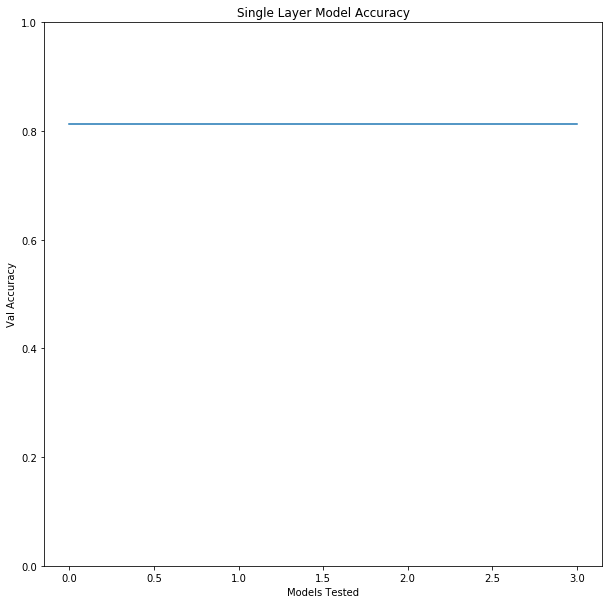

In [5]:
x_i = list(range(0, len(x)))

plt.figure(figsize=(10,10))
plt.title("Single Layer Model Accuracy")
plt.ylim((0, 1))
plt.xlabel("Models Tested")
plt.ylabel("Val Accuracy")
plt.plot(x_i, y)

In [6]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma


def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(10, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size': 30}
    )

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    x_obs = np.array([[res["params"]["layer1"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])

    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]),
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
              alpha=.6, fc='c', ec='None', label='95% confidence interval')

    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f( layer1 )', fontdict={'size': 20})
    axis.set_xlabel('layer1', fontdict={'size': 20})

    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15,
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size': 20})
    acq.set_xlabel('layer1', fontdict={'size': 20})

    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

epoch,train_loss,valid_loss,accuracy,time
0,0.700043,0.675122,0.806147,00:00
1,0.697653,0.666478,0.813239,00:00
2,0.691366,0.652525,0.813239,00:00
3,0.684314,0.634100,0.813239,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.638409,0.648138,0.813239,00:00
1,0.638758,0.642784,0.813239,00:00
2,0.643116,0.629895,0.813239,00:00
3,0.631232,0.614476,0.813239,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.755818,0.701027,0.347518,00:00
1,0.755462,0.696234,0.401891,00:00
2,0.727797,0.685303,0.801418,00:00
3,0.712155,0.668078,0.758865,00:00
4,0.695257,0.640758,0.773050,00:00
5,0.696844,0.603050,0.815603,00:00
6,0.681399,0.560691,0.827423,00:00
7,0.659862,0.519099,0.829787,00:00
8,0.643518,0.485971,0.829787,00:00
9,0.630971,0.467187,0.829787,00:00


Epoch 10: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.704687,0.705649,0.678487,00:00
1,0.694292,0.687623,0.690307,00:00
2,0.697763,0.669029,0.598109,00:00
3,0.675091,0.653759,0.574468,00:00
4,0.679072,0.622272,0.822695,00:00
5,0.671126,0.584008,0.822695,00:00
6,0.656925,0.547654,0.822695,00:00
7,0.642761,0.515676,0.822695,00:00


Epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.743054,0.715754,0.179669,00:00
1,0.726314,0.707464,0.182033,00:00
2,0.717296,0.690413,0.614657,00:00
3,0.701524,0.669774,0.737589,00:00
4,0.687759,0.645509,0.784870,00:00
5,0.682418,0.605437,0.813239,00:00
6,0.663720,0.564097,0.810875,00:00
7,0.665015,0.525418,0.815603,00:00
8,0.652946,0.496091,0.820331,00:00


Epoch 9: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.756303,0.716383,0.234043,00:00
1,0.749670,0.716256,0.219858,00:00
2,0.740978,0.717190,0.189125,00:00
3,0.726805,0.708667,0.527187,00:00
4,0.717491,0.679021,0.666667,00:00
5,0.710936,0.643994,0.799054,00:00
6,0.698220,0.615057,0.777778,00:00
7,0.677080,0.570290,0.794326,00:00
8,0.667935,0.526226,0.799054,00:00


Epoch 9: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.667451,0.650994,0.822695,00:00
1,0.669689,0.657508,0.768322,00:00
2,0.661346,0.669266,0.633570,00:00
3,0.650343,0.673707,0.633570,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.713255,0.666170,0.813239,00:00
1,0.707727,0.664912,0.813239,00:00
2,0.700164,0.662732,0.666667,00:00
3,0.692892,0.656400,0.706856,00:00


Epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.746131,0.728279,0.184397,00:00
1,0.723438,0.712869,0.236407,00:00
2,0.709268,0.688942,0.654846,00:00
3,0.702031,0.658570,0.803783,00:00
4,0.686947,0.629474,0.782506,00:00
5,0.676134,0.594018,0.817967,00:00
6,0.667819,0.561673,0.817967,00:00
7,0.648776,0.531580,0.817967,00:00
8,0.628078,0.505783,0.813239,00:00


Epoch 9: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.705798,0.693876,0.397163,00:00
1,0.698791,0.688333,0.619385,00:00
2,0.696554,0.678343,0.768322,00:00
3,0.686033,0.663489,0.799054,00:00
4,0.682534,0.635690,0.813239,00:00
5,0.674564,0.596869,0.808511,00:00
6,0.670024,0.566505,0.815603,00:00
7,0.650264,0.538247,0.815603,00:00


Epoch 8: early stopping


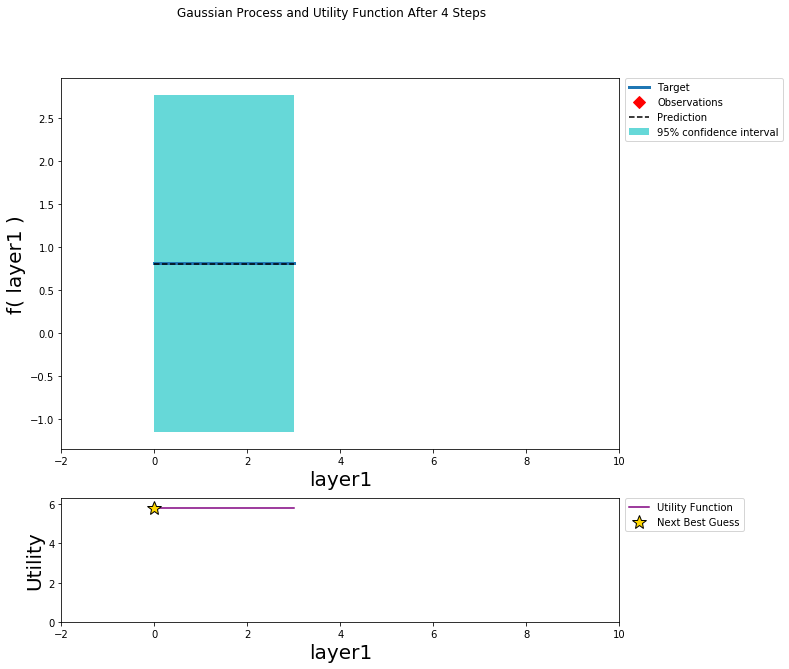

In [7]:
bayesian_optimizer.optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(bayesian_optimizer.optimizer, np.array(x_i).reshape(-1, 1), y)

# Recommendation
Via Baysian Optimization, find the params that need to change to reduce the likelihood someone experience depression.

In [9]:
from src.recommender.JSONParamReader import JSONParamReader
import pprint
import warnings
from pandas.io.json import json
import pandas as pd
from bayes_opt import BayesianOptimization, Events, JSONLogger
from fastai.basic_data import DataBunch, Tensor
import numpy as np
from src.classifier.CustomTabularModel import CustomTabularModel
from src.data.DataCsvInterface import DataCsvInterface
from src.recommender.JSONParamReader import JSONParamReader

warnings.simplefilter(action='ignore', category=FutureWarning)

bayesian_optimizer = BayesianRecommender(100, 30)
# Init the model with the best params
model = CustomTabularModel(0.5, False, 1000, {'layer1': 20, 'layer2': 20})
best_params = JSONParamReader('classifier/logs').get_best_param()
model.reset_params(best_params)
pp = pprint.PrettyPrinter(indent=4)
print("        Using Model Architecture")
pp.pprint( best_params)

        Using Model Architecture
{'dropout': 0.4170220047, 'layer1': 288.4094728834}


In [10]:
data = model.input_data.train_ds[40][0]
data_parsed = []
for element in data.data:
    if type(element) is Tensor:
        data_parsed += list(element.numpy())
    else:
        data_parsed += element


data_init = {key: data_parsed[i] for i, key in enumerate(data.names)}
cr = bayesian_optimizer.get_ranges(data.names, model.input_data.train_ds)
column_range = {key: cr[key] for key in cr if key not in DataCsvInterface.FIXED_NAMES}
model.train(90)

epoch,train_loss,valid_loss,accuracy,time
0,0.694677,0.655348,0.846808,00:00
1,0.692843,0.652048,0.846808,00:00
2,0.679254,0.641403,0.846808,00:00
3,0.668598,0.623086,0.846808,00:00


Epoch 4: early stopping


0.8468084931373596

In [28]:
bayesian_optimizer = BayesianRecommender(300, 200)
bayesian_optimizer.run_optimization(model, data_init, column_range)

Value to maximize: 0.4463542699813843
Value to maximize: 0.44635286927223206
Keeping results: {'target': 0.44635286927223206, 'params': {'friends': 1.0, 'gender_categorical': 1.0, 'income_float': 1.0}}


    age


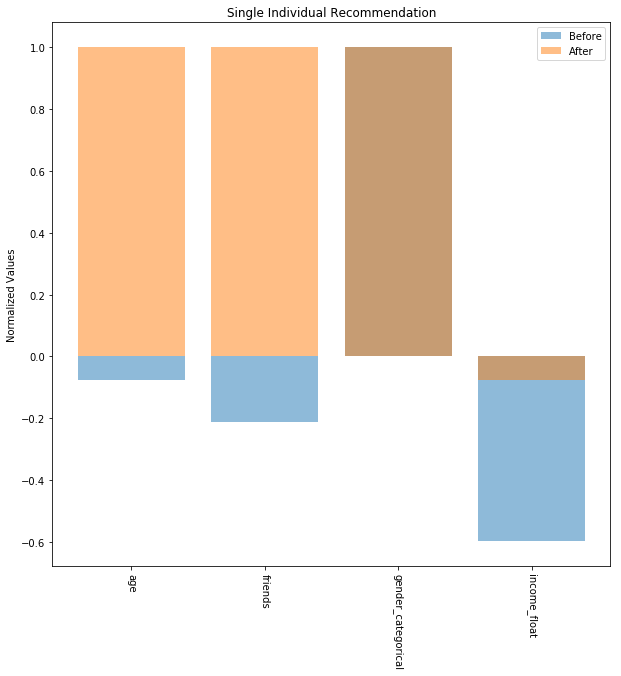

In [20]:
after_data = bayesian_optimizer.results[0]['params']
data_init = {key: data_parsed[i] for i, key in enumerate(data.names)}

# Sort both dictionaries by keys
data_init = {i:data_init[i] for i in sorted(data_init.keys())}
after_data = {i:after_data[i] for i in sorted([_ for _ in after_data.keys() if _ != 1]) 
              if i != 1}

# Exclude changing your sexuality lol
# del data_init['sexuallity_categorical']
# del after_data['sexuallity_categorical']
# del data_init['pay_for_sex_categorical']
# del after_data['pay_for_sex_categorical']
# del data_init['virgin_categorical']
# del after_data['virgin_categorical']


# Before Data
feature_data = [data_init[_] for _ in data_init]
feature_pos = list(range(len(feature_data)))
objects = [_ for _ in data_init]
# Fill in any missing data for running predictions
for key in data_init:
    if key not in after_data:
        print("    "+ str(key))
        after_data[key] = data_init[key]

after_feature_data = [after_data[_] for _ in after_data]
after_feature_pos = list(range(len(after_feature_data)))
after_objects = [_ for _ in after_data]

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}


plt.figure(figsize=(10, 10))
b1 = plt.bar(feature_pos, feature_data, align='center', alpha=0.5)
b2 = plt.bar(after_feature_pos, after_feature_data, align='center', alpha=0.5)
plt.xticks(feature_pos, objects, rotation=-90)
plt.ylabel('Normalized Values')
plt.title('Single Individual Recommendation')
plt.legend((b1[0], b2[0]), ('Before', 'After'))
plt.show()

In [21]:
data_init

{'age': -0.0751691,
 'friends': -0.21313006,
 'gender_categorical': 1,
 'income_float': -0.59635216}

In [22]:
changes = np.abs(np.subtract(feature_data, after_feature_data))
directions = np.sign(np.subtract(feature_data, after_feature_data))

In [23]:
n = 3
max_categories = np.argsort(changes)[-n:][::-1]

In [24]:
model = CustomTabularModel(0.5, False, 1000, {'layer1': 20, 'layer2': 20})


In [30]:
model.predict(after_data)

(Category 2, tensor(1), tensor([0.4464, 0.5536]))

In [26]:
after_data

{'friends': 1.0,
 'gender_categorical': 1.0,
 'income_float': 1.0,
 'age': -0.0751691}

In [31]:
model.predict(data_init)

(Category 2, tensor(1), tensor([0.4464, 0.5536]))